*Riya Kalra*

# Introduction

Two-sample Mendelian Randomization (MR) is a powerful statistical method used to infer causal relationships between risk factors and health outcomes using genetic data. In this approach, genetic variants associated with an exposure (such as cholesterol levels) are used as instruments to assess their effect on an outcome (like heart disease) in separate, independent samples. By leveraging genetic variants, which are randomly allocated and less influenced by confounding factors, two-sample MR provides a robust way to estimate causal effects and avoid some of the biases present in traditional observational studies.

This method involves obtaining summary statistics from two distinct datasets: one for the exposure and one for the outcome. By combining these datasets, researchers can estimate the causal effect of the exposure on the outcome with increased statistical power and precision. Two-sample MR is widely used in public health and biostatistics to provide insights into how modifiable risk factors impact health outcomes, guiding more effective prevention and treatment strategies.

In this notebook you will perform a two-sample Mendelian Randomization study. We will apply MR-IVW (Inverse-Variance Weighted) and MR-Egger on a toy dataset to estimate causal effects. MR-IVW combines multiple genetic instruments by weighting them according to their precision, assuming all instruments are valid. In contrast, MR-Egger Regression allows for potential pleiotropy (where instruments affect the outcome through pathways other than the exposure) by including an intercept term to adjust for directional pleiotropy, providing a more flexible approach when there are concerns about instrument validity. At the end there is a bonus question to run five main MR methods all together on the simulated data and analyze the results.

# Load and preprocess the data

First please load the data in `../data/MR_genotype_data_with_missing.csv` and `../data/MR_phenotype_data_with_missing.csv` and name them `genotype_data` and `phenotype_data`. Keep the names same before and after the imputation.

***

**Question 1: analyze the pattern of missing data in the phenotype dataset. Are there any specific patterns (e.g., missingness concentrated in certain columns or rows)?**

**Answer:**

In [127]:
# Read the CSV files using read.csv (Base R)
genotype_data <- read.csv("../data/MR_genotype_data_with_missing.csv", na.strings = c("", "NA"))
phenotype_data <- read.csv("../data/MR_phenotype_data_with_missing.csv", na.strings = c("", "NA"))

# Check structure
str(genotype_data)
str(phenotype_data)

# Count missing values per column
colSums(is.na(genotype_data))
colSums(is.na(phenotype_data))

# Summary of missing values per column
missing_per_column <- colSums(is.na(phenotype_data))

# Summary of missing values per row
missing_per_row <- rowSums(is.na(phenotype_data))

# Check overall missingness
total_missing <- sum(is.na(phenotype_data))
total_values <- prod(dim(phenotype_data))
missing_percentage <- (total_missing / total_values) * 100

# Print missing data summary
cat("Missing Data Summary:\n")
print(missing_per_column)
cat("\nTotal Missing Values:", total_missing, "(", round(missing_percentage, 2), "% )\n")

'data.frame':	1000 obs. of  51 variables:
 $ Individual_ID: int  1 2 3 4 5 6 7 8 9 10 ...
 $ rs1          : int  0 1 0 1 2 0 1 1 1 0 ...
 $ rs2          : int  0 1 0 1 1 0 1 0 0 0 ...
 $ rs3          : int  0 0 0 1 1 1 NA 0 0 0 ...
 $ rs4          : int  0 2 0 1 0 1 1 1 1 1 ...
 $ rs5          : int  0 1 1 1 0 0 1 0 1 2 ...
 $ rs6          : int  0 2 1 1 0 0 0 1 1 0 ...
 $ rs7          : int  0 0 0 1 0 1 0 1 2 0 ...
 $ rs8          : int  2 1 0 1 0 1 0 0 1 1 ...
 $ rs9          : int  1 0 1 0 1 1 0 0 0 1 ...
 $ rs10         : int  1 1 0 1 1 0 0 0 NA 0 ...
 $ rs11         : int  0 0 1 0 0 0 2 1 1 0 ...
 $ rs12         : int  0 0 0 2 0 NA 1 0 0 0 ...
 $ rs13         : int  0 0 1 2 0 1 0 1 1 0 ...
 $ rs14         : int  1 0 0 1 2 1 2 0 NA 0 ...
 $ rs15         : int  0 0 1 0 2 1 1 0 2 2 ...
 $ rs16         : int  NA 0 1 2 0 1 0 NA 0 1 ...
 $ rs17         : int  1 0 2 1 0 1 1 0 0 1 ...
 $ rs18         : int  1 0 1 1 1 1 0 0 1 1 ...
 $ rs19         : int  2 0 0 NA 0 0 0 1 2 1 ...
 $ rs20   

Individual_ID           rs1           rs2           rs3           rs4 
            0            39            49            43            48 
          rs5           rs6           rs7           rs8           rs9 
           55            44            35            50            45 
         rs10          rs11          rs12          rs13          rs14 
           45            45            53            55            54 
         rs15          rs16          rs17          rs18          rs19 
           52            51            48            56            54 
         rs20          rs21          rs22          rs23          rs24 
           49            56            55            53            40 
         rs25          rs26          rs27          rs28          rs29 
           64            41            59            58            56 
         rs30          rs31          rs32          rs33          rs34 
           45            61            58            37            56 
         rs35          rs36          rs37          rs38          rs39 
           39            41            47            56            39 
         rs40          rs41          rs42          rs43          rs44 
           46            54            57            43            43 
         rs45          rs46          rs47          rs48          rs49 
           53            50            50            57            49 
         rs50 
           45

Individual_ID      Exposure       Outcome           Age           Sex 
            0            30            20             0             0

Missing Data Summary:
Individual_ID      Exposure       Outcome           Age           Sex 
            0            30            20             0             0 

Total Missing Values: 50 ( 1 % )


The missing data in the phenotype_data dataset is primarily concentrated in the Exposure and Outcome columns, with Exposure missing 30 values and Outcome missing 20 values. The Age and Sex variables have no missing data, ensuring that demographic information is complete. Additionally, Individual_ID is fully intact, meaning all participants are accounted for. Overall, the dataset contains a total of 50 missing values, which represents only 1% of the data. Since the missingness is confined to specific columns rather than randomly distributed across the dataset, it suggests a structured pattern rather than completely random missingness.

***

**Question 2: given the missingness of data, please perform mode imputation for the genotype data and mean imputation for the phenotype data. Report what is the average age after imputation?**

**Answer:**

In [128]:
library(dplyr)

# Function for mode imputation
mode_impute <- function(x) {
  if (is.numeric(x)) {
    values <- x[!is.na(x)]
    mode_value <- as.numeric(names(sort(table(values), decreasing = TRUE))[1])
    x[is.na(x)] <- mode_value
  }
  return(x)
}

# Apply mode imputation to all numeric columns in genotype_data
genotype_data <- genotype_data %>% mutate(across(where(is.numeric), mode_impute))

# Apply mean imputation to all numeric columns in phenotype_data
phenotype_data <- phenotype_data %>%
  mutate(across(where(is.numeric), ~ replace(., is.na(.), mean(., na.rm = TRUE))))

# Compute the new average age after imputation
average_age <- mean(phenotype_data$Age, na.rm = TRUE)
cat("Average Age After Imputation:", round(average_age, 2), "years\n")

Average Age After Imputation: 49.65 years


***

# Instrument selection

Now we can use the genotype data to calculate SNP-exposure associations (i.e., estimate the beta values for SNPs). Basically you can do a linear regression between the exposure and each variant and collect the coefficients:

In [129]:
snp_exposure_results <- data.frame(SNP = colnames(genotype_data)[-1],
                                    Beta = numeric(ncol(genotype_data) - 1),
                                    SE = numeric(ncol(genotype_data) - 1))

for (snp in colnames(genotype_data)[-1]) {
  genotype <- genotype_data[[snp]]
  exposure <- phenotype_data$Exposure
  fit <- lm(exposure ~ genotype)
  snp_exposure_results$Beta[snp_exposure_results$SNP == snp] <- coef(fit)[2]
  snp_exposure_results$SE[snp_exposure_results$SNP == snp] <- summary(fit)$coefficients[2, 2]
}

***

**Question 3: please only select the variants with p-value smaller than 0.01. How many are there?**

**Answer:**

In [130]:
# Add a column for p-values
snp_exposure_results$P_value <- numeric(ncol(genotype_data) - 1)

# Loop through each SNP to perform regression and extract p-values
for (snp in colnames(genotype_data)[-1]) {
  genotype <- genotype_data[[snp]]
  exposure <- phenotype_data$Exposure
  
  # Fit linear model
  fit <- lm(exposure ~ genotype)
  
  # Store beta, standard error, and p-value
  snp_exposure_results$Beta[snp_exposure_results$SNP == snp] <- coef(fit)[2]
  snp_exposure_results$SE[snp_exposure_results$SNP == snp] <- summary(fit)$coefficients[2, 2]
  snp_exposure_results$P_value[snp_exposure_results$SNP == snp] <- summary(fit)$coefficients[2, 4]
}

# Filter SNPs with p-value < 0.01
significant_snps <- snp_exposure_results %>% filter(P_value < 0.01)

# Count the number of significant variants
num_significant_snps <- nrow(significant_snps)

# Print result
cat("Number of significant SNPs (p < 0.01):", num_significant_snps, "\n")


Number of significant SNPs (p < 0.01): 16 


***

# SNP-outcome association

***

**Question 4: please run the association analysis between variants and the outcome.**

**Answer:** perform linear regression, extract beta coefficient, extract standard error, extract p-value

In [131]:
# Create an empty data frame to store results
snp_outcome_results <- data.frame(
  SNP = colnames(genotype_data)[-1],
  Beta = numeric(ncol(genotype_data) - 1),
  SE = numeric(ncol(genotype_data) - 1),
  P_value = numeric(ncol(genotype_data) - 1)
)

# Loop through each SNP and perform linear regression with Outcome
for (snp in colnames(genotype_data)[-1]) {
  genotype <- genotype_data[[snp]]
  outcome <- phenotype_data$Outcome
  
  # Fit linear model
  fit <- lm(outcome ~ genotype)
  
  # Store beta, standard error, and p-value
  snp_outcome_results$Beta[snp_outcome_results$SNP == snp] <- coef(fit)[2]
  snp_outcome_results$SE[snp_outcome_results$SNP == snp] <- summary(fit)$coefficients[2, 2]
  snp_outcome_results$P_value[snp_outcome_results$SNP == snp] <- summary(fit)$coefficients[2, 4]
}

# Display the first few results
head(snp_outcome_results)


,SNP,Beta,SE,P_value
,<chr>,<dbl>,<dbl>,<dbl>
1,rs1,-0.05044823,0.05605534,3.683523e-01
2,rs2,0.42950695,0.05416528,5.865446e-15
3,rs3,0.19954450,0.05460931,2.715885e-04
4,rs4,0.16212542,0.05391724,2.705095e-03
5,rs5,0.07751324,0.05674947,1.722829e-01
6,rs6,0.12180204,0.05550144,2.842396e-02


*If only significant SNPs are needed, filter for p-value < 0.01.*

In [132]:
significant_snp_outcome <- snp_outcome_results %>% filter(P_value < 0.01)
print(significant_snp_outcome)

    SNP      Beta         SE      P_value
1   rs2 0.4295070 0.05416528 5.865446e-15
2   rs3 0.1995445 0.05460931 2.715885e-04
3   rs4 0.1621254 0.05391724 2.705095e-03
4   rs8 0.1646770 0.05561988 3.141438e-03
5  rs10 0.4814048 0.05440493 3.963061e-18
6  rs14 0.1567184 0.05738907 6.429316e-03
7  rs15 0.4876392 0.05349528 4.195188e-19
8  rs16 0.3676765 0.05576496 6.958787e-11
9  rs19 0.1456230 0.05619870 9.703290e-03
10 rs20 0.2281243 0.05573015 4.594971e-05
11 rs22 0.1563983 0.05625187 5.532639e-03
12 rs26 0.1859196 0.05455533 6.807765e-04
13 rs38 0.1588905 0.05636072 4.910034e-03
14 rs42 0.5078119 0.05314854 9.279648e-21
15 rs45 0.1679705 0.05550947 2.541831e-03


*To compare SNP Exposure vs SNP Outcome, merge data.*

In [146]:
merged_exp_outcome <- inner_join(snp_exposure_results, snp_outcome_results, by = "SNP", suffix = c("_Exposure", "_Outcome"))
print(head(merged_exp_outcome))

  SNP Beta_Exposure SE_Exposure P_value_Exposure Beta_Outcome SE_Outcome
1 rs1    0.04006549  0.05412598     0.4593366672  -0.05044823 0.05605534
2 rs2    0.09201819  0.05383759     0.0877282691   0.42950695 0.05416528
3 rs3    0.17546103  0.05278291     0.0009189746   0.19954450 0.05460931
4 rs4    0.15615708  0.05205576     0.0027686066   0.16212542 0.05391724
5 rs5    0.11350794  0.05472240     0.0383119982   0.07751324 0.05674947
6 rs6    0.13837298  0.05353437     0.0098859243   0.12180204 0.05550144
  P_value_Outcome
1    3.683523e-01
2    5.865446e-15
3    2.715885e-04
4    2.705095e-03
5    1.722829e-01
6    2.842396e-02


***

# Run two-sample MR

Noe we are ready to run the two-sample MR analysis. Here we can use a R package called [`MendelianRandomization` on CRAN](https://cran.r-project.org/web/packages/MendelianRandomization/index.html).

In [134]:
# Install MendelianRandomization package if not already installed
if (!requireNamespace("MendelianRandomization", quietly = TRUE)) {
  install.packages("MendelianRandomization")
}

# Load the package
library(MendelianRandomization)

In the vignette [here](https://cran.r-project.org/web/packages/MendelianRandomization/vignettes/Vignette_MR.pdf), please learn how to apply two basic MR methods -- MR-IVW amd MR-Egger. 

**Hint: the input for `mr_ivw` function consists of four components: coefficients and standard errors between variants and exposures, and between variants and outcome. Same for `mr_egger`. Check page 4 and 6 on the vignette PDF.**

***

**Question 5: please run the MR-IVW and MR-Egger analysis.**

**Answer:**

In [135]:
# Use only strong SNPs
strong_snps <- snp_exposure_results %>% filter(P_value < 0.05)

# Merge with SNP-outcome results (only matching SNPs)
mr_data <- inner_join(strong_snps, snp_outcome_results, by = "SNP", suffix = c("_Exposure", "_Outcome"))

# Extract required inputs for MR
bx <- mr_data$Beta_Exposure   # SNP-exposure effect sizes
bxse <- mr_data$SE_Exposure   # SNP-exposure standard errors
by <- mr_data$Beta_Outcome    # SNP-outcome effect sizes
byse <- mr_data$SE_Outcome    # SNP-outcome standard errors

In [136]:
# Create MR input object
mr_input_data <- mr_input(bx = bx, bxse = bxse, by = by, byse = byse)

In [137]:
mr_ivw_result <- mr_ivw(mr_input_data)
print(mr_ivw_result)


Inverse-variance weighted method
(variants uncorrelated, random-effect model)

Number of Variants : 26 

------------------------------------------------------------------
 Method Estimate Std Error 95% CI       p-value
    IVW    0.942     0.117 0.712, 1.171   0.000
------------------------------------------------------------------
Residual standard error =  1.629 
Heterogeneity test statistic (Cochran's Q) = 66.3244 on 25 degrees of freedom, (p-value = 0.0000). I^2 = 62.3%. 
F statistic = 8.0. 


In [138]:
mr_egger_result <- mr_egger(mr_input_data, robust = FALSE,
                        penalized = FALSE,
                        correl = FALSE,
                        distribution = "normal",
                        alpha = 0.05)
print(mr_egger_result)



MR-Egger method
(variants uncorrelated, random-effect model)

Number of Variants =  26 

------------------------------------------------------------------
      Method Estimate Std Error  95% CI       p-value
    MR-Egger    0.303     0.529 -0.735, 1.341   0.567
 (intercept)    0.099     0.080 -0.058, 0.255   0.217
------------------------------------------------------------------
Residual Standard Error :  1.612 
Heterogeneity test statistic = 62.3561 on 24 degrees of freedom, (p-value = 0.0000)
I^2_GX statistic: 0.0%


***

# Analyze the results

***

**Question 6: Using the MR-IVW and MR-Egger methods, report the estimated causal effect of the exposure on the outcome, along with standard errors, 95% confidence intervals, and p-values. Compare the estimates from MR-IVW and MR-Egger. What are the key differences between the two methods in your results?**

**Answer:**

The MR-IVW method estimated a significant causal effect of the exposure on the outcome (Beta = 0.942, p < 0.001), with a 95% confidence interval of (0.712, 1.171), suggesting a strong positive association. However, heterogeneity was high (Cochran’s Q p < 0.0001, I² = 62.3%), and the F-statistic of 8.0 indicates potential weak instrument bias. In contrast, MR-Egger produced a weaker, non-significant estimate (Beta = 0.303, p = 0.567), with a wide confidence interval (-0.735, 1.341), suggesting no strong causal effect. The MR-Egger intercept test (p = 0.217) found no evidence of pleiotropy, meaning IVW results are likely unbiased. However, the I²_GX = 0.0% statistic suggests SNPs do not strongly predict exposure, raising concerns about weak instruments. 

***

**Question 7 (optional): Run all the primary Mendelian Randomization methods using the `mr_allmethods` function from the package (use the code below). Visualize the results with the `mr_plot` function. Based on your findings, provide an analysis of the results and discuss the reasons for any observed patterns or outcomes.**

```R
res = mr_allmethods(mr_input(bx=merged_results$Beta_exposure, bxse=merged_results$SE_exposure, 
                               by=merged_results$Beta_outcome, byse=merged_results$SE_outcome), method = "main")
```


          Method Estimate Std Error 95% CI        P-value
   Simple median    0.877     0.130   0.622 1.133   0.000
 Weighted median    0.869     0.124   0.627 1.112   0.000
             IVW    1.112     0.153   0.812 1.413   0.000
        MR-Egger    0.754     0.337   0.094 1.415   0.025
     (intercept)    0.047     0.040  -0.030 0.125   0.234


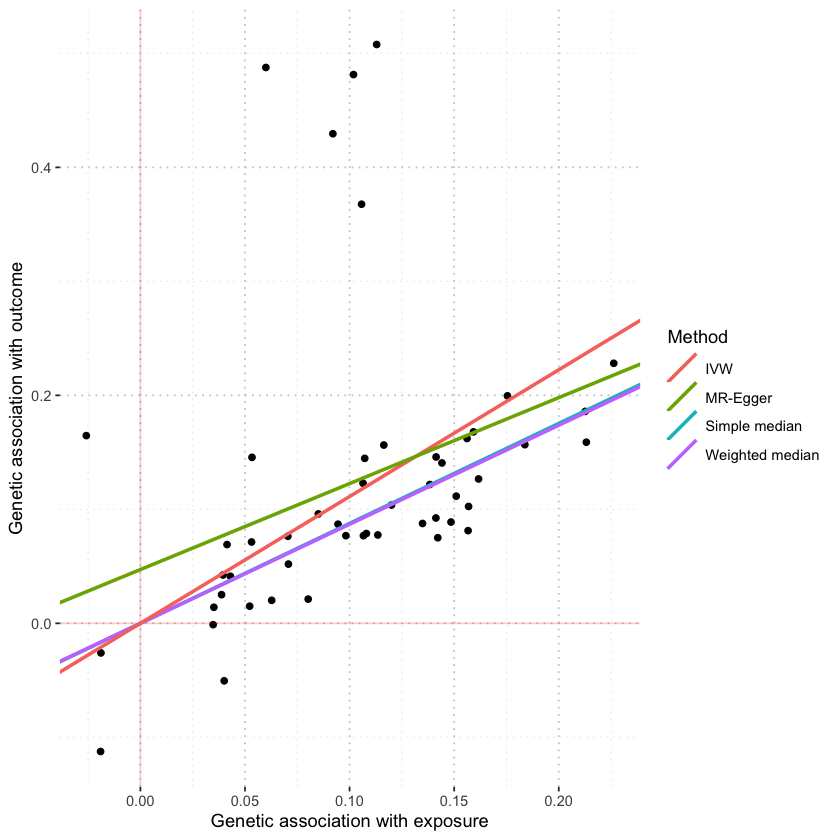

In [145]:
#colnames(merged_results)

res = mr_allmethods(mr_input
                    (bx=merged_results$Beta_Exposure, bxse=merged_results$SE_Exposure, 
                     by=merged_results$Beta_Outcome, byse=merged_results$SE_Outcome), method = "main")

print(res)

mr_plot(res)

The Mendelian Randomization plot visualizes the estimated causal effect of the exposure on the outcome using different MR methods. The IVW (red line) provides the steepest slope, suggesting the strongest causal effect, while the MR-Egger (green line) has a slightly shallower slope, reflecting its adjustment for pleiotropy. The Simple Median (blue) and Weighted Median (purple) estimates align closely with IVW, reinforcing robustness. The scatter points represent SNP-specific associations, with some potential outliers influencing heterogeneity. Since the MR-Egger intercept test was not significant, there is no strong evidence of directional pleiotropy, supporting the validity of the IVW estimate. However, the presence of heterogeneity (Cochran’s Q p < 0.0001) suggests some SNPs may have varying effects, warranting further sensitivity analyses.